Sherly Santiadi (2072025)

# Prepare Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
path="/content/drive/My Drive/praktikum-ml/drug.csv"

Mounted at /content/drive


# Import Library

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from scipy.stats import shapiro
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
from graphviz import Source
from sklearn.tree import export_graphviz
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import tree
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score,StratifiedKFold
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# EDA

From this data we would see the range from age and Na_to_K. We need to do data binning

In [ ]:
df=pd.read_csv(path)
df

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,DrugY
...,...,...,...,...,...,...
195,56,F,LOW,HIGH,11.567,drugC
196,16,M,LOW,HIGH,12.006,drugC
197,52,M,NORMAL,HIGH,9.894,drugX
198,23,M,NORMAL,NORMAL,14.020,drugX


From this data visualization we notice that 'DrugY' is oversampling. We need to do handle this imbalanced data later.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


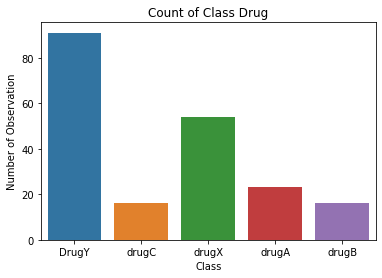

In [ ]:
sns.countplot('Drug',data=df)
plt.title('Count of Class Drug')
plt.xlabel('Class')
plt.ylabel('Number of Observation')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


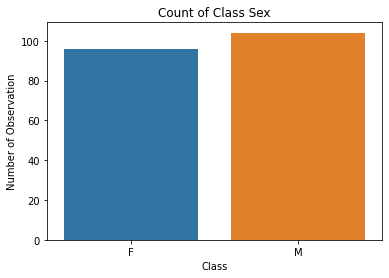

In [ ]:
sns.countplot('Sex',data=df)
plt.title('Count of Class Sex')
plt.xlabel('Class')
plt.ylabel('Number of Observation')
plt.show()

In [ ]:
df["Drug"].value_counts() 

DrugY    91
drugX    54
drugA    23
drugC    16
drugB    16
Name: Drug, dtype: int64

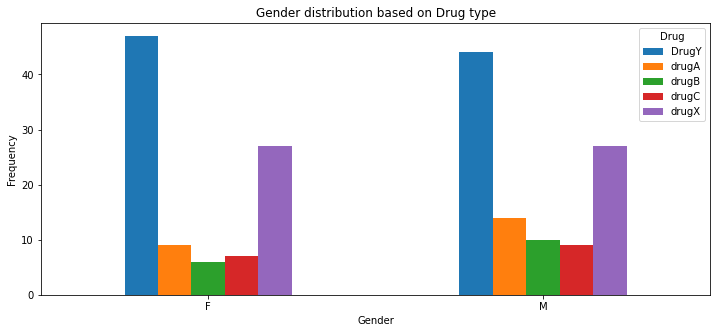

In [ ]:
pd.crosstab(df.Sex,df.Drug).plot(kind="bar",figsize=(12,5))
plt.title('Gender distribution based on Drug type')
plt.xlabel('Gender')
plt.xticks(rotation=0)
plt.ylabel('Frequency')
plt.show()

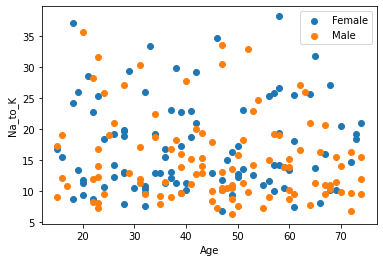

In [ ]:
plt.scatter(x=df.Age[df.Sex=='F'], y=df.Na_to_K[(df.Sex=='F')])
plt.scatter(x=df.Age[df.Sex=='M'], y=df.Na_to_K[(df.Sex=='M')])
plt.legend(["Female", "Male"])
plt.xlabel("Age")
plt.ylabel("Na_to_K")
plt.show()

<Figure size 720x360 with 0 Axes>

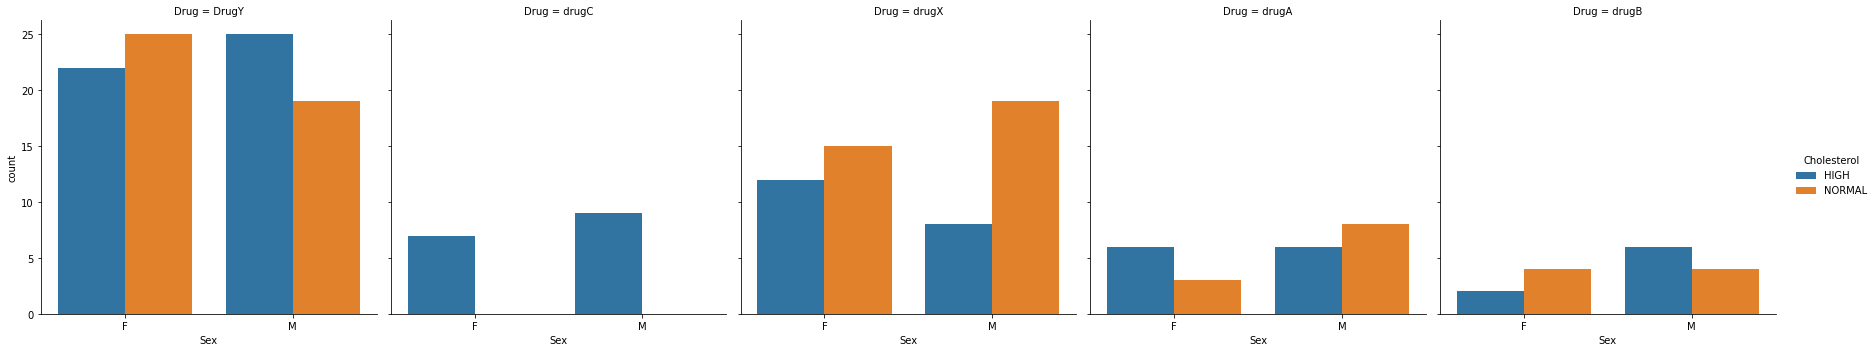

In [ ]:
plt.figure(figsize = (10,5))
g = sns.catplot(x="Sex", hue="Cholesterol", col="Drug",
                data=df, kind="count",
                height=5)

Text(0.5, 1.0, 'Correlation between different fearures')

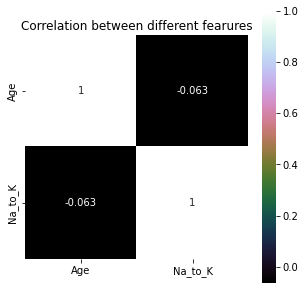

In [ ]:
correlation = df.corr()
plt.figure(figsize=(5,5))
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')
plt.title('Correlation between different fearures')

## Info

In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          200 non-null    int64  
 1   Sex          200 non-null    object 
 2   BP           200 non-null    object 
 3   Cholesterol  200 non-null    object 
 4   Na_to_K      200 non-null    float64
 5   Drug         200 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 9.5+ KB
None


## Null Data

In [ ]:
null_data=df.isna().sum()
null_data

Age            0
Sex            0
BP             0
Cholesterol    0
Na_to_K        0
Drug           0
dtype: int64

## Unique Data

In [ ]:
df.nunique()

Age             57
Sex              2
BP               3
Cholesterol      2
Na_to_K        198
Drug             5
dtype: int64

## Describe Data

In [ ]:
vectorizer=CountVectorizer(lowercase=False)
vectorizer.fit_transform(df)
feat_dict=vectorizer.vocabulary_.keys()
feat_dict

dict_keys(['Age', 'Sex', 'BP', 'Cholesterol', 'Na_to_K', 'Drug'])

In [ ]:
df.describe()

,Age,Na_to_K
count,200.000000,200.000000
mean,44.315000,16.084485
std,16.544315,7.223956
min,15.000000,6.269000
25%,31.000000,10.445500
50%,45.000000,13.936500
75%,58.000000,19.380000
max,74.000000,38.247000


# Data Binning

Age will be divided into 7 categories
*   below 20 yo
*   20 - 29 yo
*   30 - 39 yo
*   40 - 49 yo
*   50 - 59 yo
*   60 - 69 yo
*   above 70 yo

In [ ]:
bin_age = [0, 19, 29, 39, 49, 59, 69, 80]
category_age = ['<20', '20', '30', '40', '50', '60', '>60']
df['Age_binned'] = pd.cut(df['Age'], bins=bin_age, labels=category_age)
df = df.drop(['Age'], axis = 1)

In [ ]:
df

,Sex,BP,Cholesterol,Na_to_K,Drug,Age_binned
0,F,HIGH,HIGH,25.355,DrugY,20
1,M,LOW,HIGH,13.093,drugC,40
2,M,LOW,HIGH,10.114,drugC,40
3,F,NORMAL,HIGH,7.798,drugX,20
4,F,LOW,HIGH,18.043,DrugY,60
...,...,...,...,...,...,...
195,F,LOW,HIGH,11.567,drugC,50
196,M,LOW,HIGH,12.006,drugC,<20
197,M,NORMAL,HIGH,9.894,drugX,50
198,M,NORMAL,NORMAL,14.020,drugX,20


Na_to_K will be divided into 7 categories
*   below 10
*   10 - 20
*   20 - 30
*   above 30

In [ ]:
bin_Nat_to_K = [0, 9, 19, 29, 50]
category_Na_to_K = ['<10', '10-20', '20-30', '>30']
df['Na_to_K_binned'] = pd.cut(df['Na_to_K'], bins=bin_Nat_to_K, labels=category_Na_to_K)
df = df.drop(['Na_to_K'], axis = 1)

In [ ]:
df

,Sex,BP,Cholesterol,Drug,Age_binned,Na_to_K_binned
0,F,HIGH,HIGH,DrugY,20,20-30
1,M,LOW,HIGH,drugC,40,10-20
2,M,LOW,HIGH,drugC,40,10-20
3,F,NORMAL,HIGH,drugX,20,<10
4,F,LOW,HIGH,DrugY,60,10-20
...,...,...,...,...,...,...
195,F,LOW,HIGH,drugC,50,10-20
196,M,LOW,HIGH,drugC,<20,10-20
197,M,NORMAL,HIGH,drugX,50,10-20
198,M,NORMAL,NORMAL,drugX,20,10-20


# Split the Dataset

In [ ]:
df.drop(["Drug"], axis=1)

,Sex,BP,Cholesterol,Age_binned,Na_to_K_binned
0,F,HIGH,HIGH,20,20-30
1,M,LOW,HIGH,40,10-20
2,M,LOW,HIGH,40,10-20
3,F,NORMAL,HIGH,20,<10
4,F,LOW,HIGH,60,10-20
...,...,...,...,...,...
195,F,LOW,HIGH,50,10-20
196,M,LOW,HIGH,<20,10-20
197,M,NORMAL,HIGH,50,10-20
198,M,NORMAL,NORMAL,20,10-20


# Feature Engineering

In here, I will use get_dummies Fronm Pandas Library for transform dataset into numerical data

In [ ]:
df_dummy = pd.get_dummies(df)

In [ ]:
df_dummy

,Sex_F,Sex_M,BP_HIGH,BP_LOW,BP_NORMAL,Cholesterol_HIGH,Cholesterol_NORMAL,Drug_DrugY,Drug_drugA,Drug_drugB,...,Age_binned_20,Age_binned_30,Age_binned_40,Age_binned_50,Age_binned_60,Age_binned_>60,Na_to_K_binned_<10,Na_to_K_binned_10-20,Na_to_K_binned_20-30,Na_to_K_binned_>30
0,1,0,1,0,0,1,0,1,0,0,...,1,0,0,0,0,0,0,0,1,0
1,0,1,0,1,0,1,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
2,0,1,0,1,0,1,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
3,1,0,0,0,1,1,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
4,1,0,0,1,0,1,0,1,0,0,...,0,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,1,0,0,1,0,1,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
196,0,1,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
197,0,1,0,0,1,1,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
198,0,1,0,0,1,0,1,0,0,0,...,1,0,0,0,0,0,0,1,0,0


## Standardize

In [ ]:
# Standardize
scaler = StandardScaler()
scaled_X = scaler.fit_transform(df_dummy)
scaled_X

array([[ 1.040833  , -1.040833  ,  1.26388393, ..., -1.23759669,
         1.93956303, -0.2847474 ],
       [-0.96076892,  0.96076892, -0.79121189, ...,  0.80801767,
        -0.51558005, -0.2847474 ],
       [-0.96076892,  0.96076892, -0.79121189, ...,  0.80801767,
        -0.51558005, -0.2847474 ],
       ...,
       [-0.96076892,  0.96076892, -0.79121189, ...,  0.80801767,
        -0.51558005, -0.2847474 ],
       [-0.96076892,  0.96076892, -0.79121189, ...,  0.80801767,
        -0.51558005, -0.2847474 ],
       [ 1.040833  , -1.040833  , -0.79121189, ...,  0.80801767,
        -0.51558005, -0.2847474 ]])

# PCA
Pca 2 component

In [ ]:
covariance_matrix = np.cov(scaled_X, rowvar=False)
eigen_values, eigen_vectors = np.linalg.eig(covariance_matrix)
sorted_key = np.argsort(eigen_values)[::-1][:2]
eigen_values, eigen_vectors = eigen_values[sorted_key], eigen_vectors[:, sorted_key]
principal_components=np.dot(scaled_X,eigen_vectors)
principal_components

array([[-2.96035387+0.j,  1.01274773+0.j],
       [ 2.27534564+0.j,  0.67550422+0.j],
       [ 2.27534564+0.j,  0.67550422+0.j],
       [ 1.38336752+0.j,  2.58890422+0.j],
       [-0.31964182+0.j,  1.11057909+0.j],
       [ 1.38336752+0.j,  2.58890422+0.j],
       [ 0.0824009 +0.j,  1.38569618+0.j],
       [ 2.27534564+0.j,  0.67550422+0.j],
       [ 0.71200191+0.j,  0.81599618+0.j],
       [-1.47467046+0.j,  0.63094684+0.j],
       [ 1.48463174+0.j,  1.26373789+0.j],
       [-3.20619271+0.j, -0.54911834+0.j],
       [ 0.63218496+0.j,  0.50381175+0.j],
       [-2.08744266+0.j,  1.90250422+0.j],
       [ 1.68010503+0.j,  1.68777736+0.j],
       [-1.82387194+0.j, -1.47005674+0.j],
       [ 1.91113433+0.j, -0.2878548 +0.j],
       [ 1.06799267+0.j, -2.44655376+0.j],
       [ 1.74974785+0.j,  1.81140675+0.j],
       [-3.20619271+0.j, -0.54911834+0.j],
       [-1.70353074+0.j,  0.8657225 +0.j],
       [-1.00835135+0.j,  1.820637  +0.j],
       [-1.23564089+0.j,  0.30940772+0.j],
       [-0.

/usr/local/lib/python3.7/dist-packages/matplotlib/collections.py:153: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


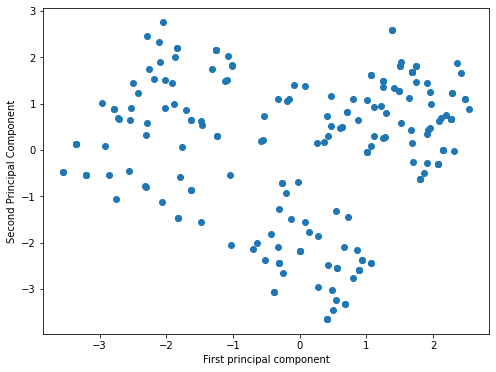

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(principal_components[:,0],principal_components[:,1])
plt.xlabel('First principal component')
plt.ylabel('Second Principal Component')
plt.grid(False)
plt.show()

In [ ]:
principal_components = PCA(n_components=2)
fitted_principal_components = principal_components.fit_transform(scaled_X)

In [ ]:
component_df = pd.DataFrame(data=fitted_principal_components,columns=["First Component","Second Component"])
component_df.head(10)

,First Component,Second Component
0,2.960354,-1.012748
1,-2.275346,-0.675504
2,-2.275346,-0.675504
3,-1.383368,-2.588904
4,0.319642,-1.110579
5,-1.383368,-2.588904
6,-0.082401,-1.385696
7,-2.275346,-0.675504
8,-0.712002,-0.815996
9,1.474670,-0.630947


In [ ]:
principal_components = PCA().fit(scaled_X)

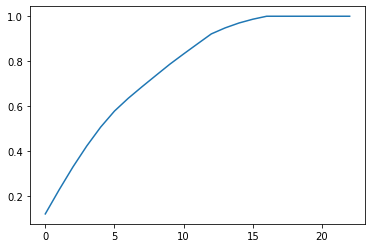

In [ ]:
plt.plot(np.cumsum(principal_components.explained_variance_ratio_))
plt.grid(False)
plt.show()

In [ ]:
X = component_df
y = df["Drug"]

In [ ]:
le = preprocessing.LabelEncoder()
y = le.fit_transform(df["Drug"])
y

array([0, 3, 3, 4, 0, 4, 0, 3, 0, 0, 3, 0, 0, 0, 4, 0, 4, 1, 3, 0, 0, 0,
       0, 0, 0, 0, 0, 4, 0, 0, 4, 2, 4, 0, 4, 4, 1, 4, 4, 4, 0, 2, 0, 4,
       4, 4, 1, 3, 0, 0, 0, 4, 0, 0, 2, 3, 2, 0, 4, 0, 0, 1, 0, 4, 2, 0,
       1, 4, 0, 0, 2, 0, 4, 0, 0, 0, 1, 0, 1, 4, 2, 4, 3, 1, 3, 2, 4, 0,
       0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 1, 1, 3, 4, 0, 4, 4, 0, 2, 0,
       1, 4, 4, 4, 4, 0, 4, 4, 1, 0, 0, 0, 0, 0, 2, 0, 0, 4, 0, 4, 0, 0,
       4, 0, 0, 4, 2, 1, 2, 4, 1, 0, 2, 0, 1, 4, 4, 1, 4, 3, 1, 2, 4, 4,
       0, 3, 1, 0, 3, 4, 4, 2, 4, 0, 0, 0, 0, 4, 0, 1, 4, 4, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 4, 4, 0, 0, 0, 2, 1, 0, 0, 0, 1, 0, 3, 0, 3, 3, 4,
       4, 4])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [ ]:
X_train
# X_test
# y_train
# y_test

,First Component,Second Component
131,1.464501,-0.544183
96,1.868713,-2.009923
181,-1.680105,-1.687777
19,3.206193,0.549118
153,-1.072973,-0.087663
...,...,...
67,-1.705705,0.250351
192,-0.423624,-0.309630
117,-1.908965,-1.453002
47,-2.114233,-0.694038


# PCA
Pca 3 components

In [ ]:
covariance_matrix = np.cov(scaled_X, rowvar=False)
eigen_values, eigen_vectors = np.linalg.eig(covariance_matrix)
sorted_key = np.argsort(eigen_values)[::-1][:3]
eigen_values, eigen_vectors = eigen_values[sorted_key], eigen_vectors[:, sorted_key]
principal_components_3=np.dot(scaled_X,eigen_vectors)
principal_components_3

array([[-2.96035387+0.j,  1.01274773+0.j, -1.15679769+0.j],
       [ 2.27534564+0.j,  0.67550422+0.j, -2.81432299+0.j],
       [ 2.27534564+0.j,  0.67550422+0.j, -2.81432299+0.j],
       [ 1.38336752+0.j,  2.58890422+0.j,  0.95627945+0.j],
       [-0.31964182+0.j,  1.11057909+0.j, -1.01325821+0.j],
       [ 1.38336752+0.j,  2.58890422+0.j,  0.95627945+0.j],
       [ 0.0824009 +0.j,  1.38569618+0.j, -0.70429282+0.j],
       [ 2.27534564+0.j,  0.67550422+0.j, -2.81432299+0.j],
       [ 0.71200191+0.j,  0.81599618+0.j, -0.95653643+0.j],
       [-1.47467046+0.j,  0.63094684+0.j,  0.51143683+0.j],
       [ 1.48463174+0.j,  1.26373789+0.j, -2.28474611+0.j],
       [-3.20619271+0.j, -0.54911834+0.j,  1.45258434+0.j],
       [ 0.63218496+0.j,  0.50381175+0.j, -1.82016836+0.j],
       [-2.08744266+0.j,  1.90250422+0.j, -1.55850527+0.j],
       [ 1.68010503+0.j,  1.68777736+0.j,  0.2077604 +0.j],
       [-1.82387194+0.j, -1.47005674+0.j,  1.17209059+0.j],
       [ 1.91113433+0.j, -0.2878548 +0.j

In [ ]:
principal_components_3 = PCA(n_components=3)
fitted_principal_components_3 = principal_components_3.fit_transform(scaled_X)

In [ ]:
component_df_3 = pd.DataFrame(data=fitted_principal_components_3,columns=["First Component","Second Component","Third Component"])
component_df_3.head(10)

,First Component,Second Component,Third Component
0,2.960354,-1.012748,-1.156798
1,-2.275346,-0.675504,-2.814323
2,-2.275346,-0.675504,-2.814323
3,-1.383368,-2.588904,0.956279
4,0.319642,-1.110579,-1.013258
5,-1.383368,-2.588904,0.956279
6,-0.082401,-1.385696,-0.704293
7,-2.275346,-0.675504,-2.814323
8,-0.712002,-0.815996,-0.956536
9,1.474670,-0.630947,0.511437


In [ ]:
principal_components_3 = PCA().fit(scaled_X)

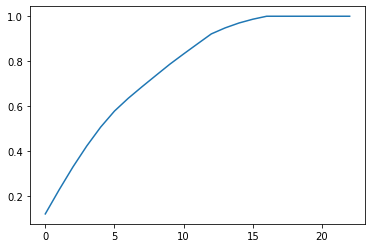

In [ ]:
plt.plot(np.cumsum(principal_components_3.explained_variance_ratio_))
plt.grid(False)
plt.show()

# Train Test Split

In [ ]:
X = component_df
y = df["Drug"]

In [ ]:
le = preprocessing.LabelEncoder()
y = le.fit_transform(df["Drug"])
y

array([0, 3, 3, 4, 0, 4, 0, 3, 0, 0, 3, 0, 0, 0, 4, 0, 4, 1, 3, 0, 0, 0,
       0, 0, 0, 0, 0, 4, 0, 0, 4, 2, 4, 0, 4, 4, 1, 4, 4, 4, 0, 2, 0, 4,
       4, 4, 1, 3, 0, 0, 0, 4, 0, 0, 2, 3, 2, 0, 4, 0, 0, 1, 0, 4, 2, 0,
       1, 4, 0, 0, 2, 0, 4, 0, 0, 0, 1, 0, 1, 4, 2, 4, 3, 1, 3, 2, 4, 0,
       0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 1, 1, 3, 4, 0, 4, 4, 0, 2, 0,
       1, 4, 4, 4, 4, 0, 4, 4, 1, 0, 0, 0, 0, 0, 2, 0, 0, 4, 0, 4, 0, 0,
       4, 0, 0, 4, 2, 1, 2, 4, 1, 0, 2, 0, 1, 4, 4, 1, 4, 3, 1, 2, 4, 4,
       0, 3, 1, 0, 3, 4, 4, 2, 4, 0, 0, 0, 0, 4, 0, 1, 4, 4, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 4, 4, 0, 0, 0, 2, 1, 0, 0, 0, 1, 0, 3, 0, 3, 3, 4,
       4, 4])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [ ]:
X_train
# X_test
# y_train
# y_test

,First Component,Second Component
131,1.464501,-0.544183
96,1.868713,-2.009923
181,-1.680105,-1.687777
19,3.206193,0.549118
153,-1.072973,-0.087663
...,...,...
67,-1.705705,0.250351
192,-0.423624,-0.309630
117,-1.908965,-1.453002
47,-2.114233,-0.694038


# Train Test Split

In [ ]:
X_3 = component_df_3
y_3 = df["Drug"]

In [ ]:
le = preprocessing.LabelEncoder()
y_3 = le.fit_transform(df["Drug"])
y_3

array([0, 3, 3, 4, 0, 4, 0, 3, 0, 0, 3, 0, 0, 0, 4, 0, 4, 1, 3, 0, 0, 0,
       0, 0, 0, 0, 0, 4, 0, 0, 4, 2, 4, 0, 4, 4, 1, 4, 4, 4, 0, 2, 0, 4,
       4, 4, 1, 3, 0, 0, 0, 4, 0, 0, 2, 3, 2, 0, 4, 0, 0, 1, 0, 4, 2, 0,
       1, 4, 0, 0, 2, 0, 4, 0, 0, 0, 1, 0, 1, 4, 2, 4, 3, 1, 3, 2, 4, 0,
       0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 1, 1, 3, 4, 0, 4, 4, 0, 2, 0,
       1, 4, 4, 4, 4, 0, 4, 4, 1, 0, 0, 0, 0, 0, 2, 0, 0, 4, 0, 4, 0, 0,
       4, 0, 0, 4, 2, 1, 2, 4, 1, 0, 2, 0, 1, 4, 4, 1, 4, 3, 1, 2, 4, 4,
       0, 3, 1, 0, 3, 4, 4, 2, 4, 0, 0, 0, 0, 4, 0, 1, 4, 4, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 4, 4, 0, 0, 0, 2, 1, 0, 0, 0, 1, 0, 3, 0, 3, 3, 4,
       4, 4])

In [ ]:
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X_3, y_3, test_size = 0.3, random_state = 0)

In [ ]:
X_train_3
# X_test_3
# y_train_3
# y_test_3

,First Component,Second Component,Third Component
131,1.464501,-0.544183,0.365679
96,1.868713,-2.009923,-1.209004
181,-1.680105,-1.687777,0.207760
19,3.206193,0.549118,1.452584
153,-1.072973,-0.087663,1.304451
...,...,...,...
67,-1.705705,0.250351,2.283077
192,-0.423624,-0.309630,-2.315428
117,-1.908965,-1.453002,0.281749
47,-2.114233,-0.694038,-2.536990


# Resampling For Oversample Data
For 2 component

In [ ]:
X_train, y_train = SMOTE().fit_resample(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


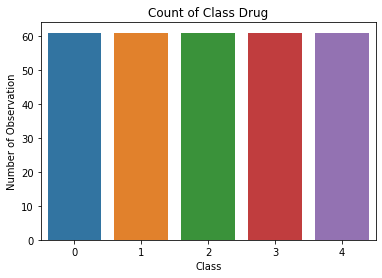

In [ ]:
sns.countplot(y_train,data=df)
plt.title('Count of Class Drug')
plt.xlabel('Class')
plt.ylabel('Number of Observation')
plt.show()

# Resampling For Oversample Data
For 3 component

In [ ]:
X_train_3, y_train_3 = SMOTE().fit_resample(X_train_3, y_train_3)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


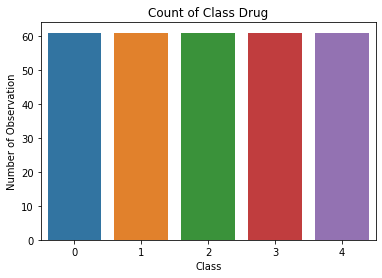

In [ ]:
sns.countplot(y_train_3,data=df)
plt.title('Count of Class Drug')
plt.xlabel('Class')
plt.ylabel('Number of Observation')
plt.show()

# Model
Using Logistic Regression 2 Component With Accuracy 75%

In [ ]:
LRclassifier = LogisticRegression(solver='liblinear', max_iter=5000)
LRclassifier.fit(X_train, y_train)

y_pred = LRclassifier.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

LogisticRegression = accuracy_score(y_pred,y_test)
print('Logistic Regression accuracy is: {:.2f}%'.format(LogisticRegression*100))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        30
           1       0.62      1.00      0.77         5
           2       0.00      0.00      0.00         3
           3       0.21      0.75      0.33         4
           4       0.88      0.39      0.54        18

    accuracy                           0.75        60
   macro avg       0.54      0.63      0.53        60
weighted avg       0.83      0.75      0.75        60

[[30  0  0  0  0]
 [ 0  5  0  0  0]
 [ 0  3  0  0  0]
 [ 0  0  0  3  1]
 [ 0  0  0 11  7]]
Logistic Regression accuracy is: 75.00%


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print('Training set score: {:.4f}'.format(LRclassifier.score(X_train, y_train)))
print('Test set score: {:.4f}'.format(LRclassifier.score(X_test, y_test)))

Training set score: 0.6361
Test set score: 0.7500


# Model
Using Logistic Regression 3 Component With Accuracy 93%

In [ ]:
LRclassifier.fit(X_train_3, y_train_3)

y_pred_3 = LRclassifier.predict(X_test_3)

print(classification_report(y_test_3, y_pred_3))
print(confusion_matrix(y_test_3, y_pred_3))

LogisticRegression3 = accuracy_score(y_pred_3,y_test_3)
print('Logistic Regression accuracy is: {:.2f}%'.format(LogisticRegression3*100))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98        30
           1       0.67      0.80      0.73         5
           2       0.50      0.33      0.40         3
           3       0.80      1.00      0.89         4
           4       1.00      1.00      1.00        18

    accuracy                           0.93        60
   macro avg       0.79      0.82      0.80        60
weighted avg       0.93      0.93      0.93        60

[[29  0  0  1  0]
 [ 0  4  1  0  0]
 [ 0  2  1  0  0]
 [ 0  0  0  4  0]
 [ 0  0  0  0 18]]
Logistic Regression accuracy is: 93.33%


In [ ]:
print('Training set score: {:.4f}'.format(LRclassifier.score(X_train_3, y_train_3)))
print('Test set score: {:.4f}'.format(LRclassifier.score(X_test_3, y_test_3)))

Training set score: 0.7770
Test set score: 0.9333


# Model
Without PCA

In [ ]:
df=pd.read_csv(path)
df

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,DrugY
...,...,...,...,...,...,...
195,56,F,LOW,HIGH,11.567,drugC
196,16,M,LOW,HIGH,12.006,drugC
197,52,M,NORMAL,HIGH,9.894,drugX
198,23,M,NORMAL,NORMAL,14.020,drugX


In [ ]:
bin_age = [0, 19, 29, 39, 49, 59, 69, 80]
category_age = ['<20', '20', '30', '40', '50', '60', '>60']
df['Age_binned'] = pd.cut(df['Age'], bins=bin_age, labels=category_age)
df = df.drop(['Age'], axis = 1)

In [ ]:
bin_Nat_to_K = [0, 9, 19, 29, 50]
category_Na_to_K = ['<10', '10-20', '20-30', '>30']
df['Na_to_K_binned'] = pd.cut(df['Na_to_K'], bins=bin_Nat_to_K, labels=category_Na_to_K)
df = df.drop(['Na_to_K'], axis = 1)

In [ ]:
df.drop(["Drug"], axis=1)

,Sex,BP,Cholesterol,Age_binned,Na_to_K_binned
0,F,HIGH,HIGH,20,20-30
1,M,LOW,HIGH,40,10-20
2,M,LOW,HIGH,40,10-20
3,F,NORMAL,HIGH,20,<10
4,F,LOW,HIGH,60,10-20
...,...,...,...,...,...
195,F,LOW,HIGH,50,10-20
196,M,LOW,HIGH,<20,10-20
197,M,NORMAL,HIGH,50,10-20
198,M,NORMAL,NORMAL,20,10-20


In [ ]:
df_dummy

,Sex_F,Sex_M,BP_HIGH,BP_LOW,BP_NORMAL,Cholesterol_HIGH,Cholesterol_NORMAL,Drug_DrugY,Drug_drugA,Drug_drugB,...,Age_binned_20,Age_binned_30,Age_binned_40,Age_binned_50,Age_binned_60,Age_binned_>60,Na_to_K_binned_<10,Na_to_K_binned_10-20,Na_to_K_binned_20-30,Na_to_K_binned_>30
0,1,0,1,0,0,1,0,1,0,0,...,1,0,0,0,0,0,0,0,1,0
1,0,1,0,1,0,1,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
2,0,1,0,1,0,1,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
3,1,0,0,0,1,1,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
4,1,0,0,1,0,1,0,1,0,0,...,0,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,1,0,0,1,0,1,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
196,0,1,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
197,0,1,0,0,1,1,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
198,0,1,0,0,1,0,1,0,0,0,...,1,0,0,0,0,0,0,1,0,0


In [ ]:
X = df
y = df["Drug"]

In [ ]:
y = le.fit_transform(df["Drug"])
y

array([0, 3, 3, 4, 0, 4, 0, 3, 0, 0, 3, 0, 0, 0, 4, 0, 4, 1, 3, 0, 0, 0,
       0, 0, 0, 0, 0, 4, 0, 0, 4, 2, 4, 0, 4, 4, 1, 4, 4, 4, 0, 2, 0, 4,
       4, 4, 1, 3, 0, 0, 0, 4, 0, 0, 2, 3, 2, 0, 4, 0, 0, 1, 0, 4, 2, 0,
       1, 4, 0, 0, 2, 0, 4, 0, 0, 0, 1, 0, 1, 4, 2, 4, 3, 1, 3, 2, 4, 0,
       0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 1, 1, 3, 4, 0, 4, 4, 0, 2, 0,
       1, 4, 4, 4, 4, 0, 4, 4, 1, 0, 0, 0, 0, 0, 2, 0, 0, 4, 0, 4, 0, 0,
       4, 0, 0, 4, 2, 1, 2, 4, 1, 0, 2, 0, 1, 4, 4, 1, 4, 3, 1, 2, 4, 4,
       0, 3, 1, 0, 3, 4, 4, 2, 4, 0, 0, 0, 0, 4, 0, 1, 4, 4, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 4, 4, 0, 0, 0, 2, 1, 0, 0, 0, 1, 0, 3, 0, 3, 3, 4,
       4, 4])

In [ ]:
X_train, y_train = SMOTE().fit_resample(X_train, y_train)

In [ ]:
LRclassifier.fit(X_train, y_train)
y_pred = LRclassifier.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
from sklearn.metrics import accuracy_score
LR_acc = accuracy_score(y_pred,y_test)
print('Logistic Regression accuracy is: {:.2f}%'.format(LR_acc*100))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        30
           1       0.62      1.00      0.77         5
           2       0.00      0.00      0.00         3
           3       0.21      0.75      0.33         4
           4       0.88      0.39      0.54        18

    accuracy                           0.75        60
   macro avg       0.54      0.63      0.53        60
weighted avg       0.83      0.75      0.75        60

[[30  0  0  0  0]
 [ 0  5  0  0  0]
 [ 0  3  0  0  0]
 [ 0  0  0  3  1]
 [ 0  0  0 11  7]]
Logistic Regression accuracy is: 75.00%


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print('Training set score: {:.4f}'.format(LRclassifier.score(X_train, y_train)))
print('Test set score: {:.4f}'.format(LRclassifier.score(X_test, y_test)))

Training set score: 0.6361
Test set score: 0.7500


In [ ]:
compare = pd.DataFrame({'Model': ['Logistic Regression PCA 2 Component', 'Logistic Regression PCA 3 Component', 'Logistic Regression Without PCA'], 
                        'Accuracy': [LogisticRegression*100, LogisticRegression3*100, LR_acc*100]})
compare.sort_values(by='Accuracy', ascending=False)

,Model,Accuracy
1,Logistic Regression PCA 3 Component,93.333333
0,Logistic Regression PCA 2 Component,75.000000
2,Logistic Regression Without PCA,75.000000


# Conclusion ✍


*   DrugY is highly imbalanced we need to handle this, I used SMOTE Technique for handle this
*   Another features such as Sex look like balanced dataset
*   I used data binning for features age & Na_to_K since the range between another features is relatively higher
*   Before feed model with dataset, I used one hot encoding from Pandas library which is dummies to transform categorical data into numerical data
*   For the label I used label encoder to transform categorical data into numerical data
*   Since datasets is relatively smaller for splitting dataset I used 30% for test set and 80% for training set (I don't use validation because I don't used Tuning technique)
*   Highest accuracy is 95% using PCA logistic model with 3 component, I thought because some features maybe uncorrelated so when we squeeze data to small (into 2 component) it would be affect into lower accuracy
